In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [7]:
# 1. Load and preprocess the data
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data


In [8]:
def preprocess_data(data):
    # Extract features (landmarks) and labels
    X = []
    y = []
    
    for item in data:
        # Extract all landmark coordinates into a flat array
        landmarks = item['landmarks']
        features = []
        for lm in landmarks:
            features.extend([lm['x'], lm['y'], lm['z']])
        
        X.append(features)
        y.append(item['label'])
    
    # Convert to numpy arrays
    X = np.array(X)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Convert to one-hot encoding
    y_onehot = to_categorical(y_encoded)
    
    return X, y_onehot, label_encoder


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_model(input_shape, num_classes):
    # Create a more sophisticated architecture with regularization
    model = Sequential([
        # First layer - increased neurons with L2 regularization
        Dense(512, activation='relu', input_shape=(input_shape,), 
              kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Second layer - additional capacity with regularization
        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Third layer - more neurons for better feature extraction
        Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Fourth layer - maintaining strong representation
        Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.2),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Use a more sophisticated optimizer configuration
    optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=True
    )
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']  # Additional metrics for better evaluation
    )
    
    return model

In [25]:

# 3. Train and evaluate
def train_and_evaluate(X, y, test_size=0.2, epochs=50, batch_size=32):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Build the model
    model = build_model(X_train.shape[1], y_train.shape[1])
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    
    # Evaluate
    results = model.evaluate(X_test, y_test)
    test_loss = results[0]
    test_acc = results[1]

    print(f"Test accuracy: {test_acc:.4f}")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes))
    
    return model, history, y_true_classes, y_pred_classes


In [26]:

# 4. Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [27]:
# 5. Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, label_encoder):
    class_names = label_encoder.classes_
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [28]:
# 6. Prediction function for new data
def predict_gesture(model, landmarks, label_encoder):
    # Process landmarks the same way as training data
    features = []
    for lm in landmarks:
        features.extend([lm['x'], lm['y'], lm['z']])
    
    # Convert to numpy array and reshape
    features = np.array(features).reshape(1, -1)
    
    # Make prediction
    prediction = model.predict(features)[0]
    predicted_class = np.argmax(prediction)
    confidence = prediction[predicted_class]
    
    # Convert class index to label
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_label, confidence


In [29]:
# 7. Save and load model
def save_model(model, label_encoder, filepath="gesture_model"):
    # Save keras model
    model.save(f"{filepath}.h5")
    
    # Save label encoder classes
    with open(f"{filepath}_labels.json", 'w') as f:
        json.dump(list(label_encoder.classes_), f)
    
    print(f"Model saved to {filepath}.h5")
    print(f"Label classes saved to {filepath}_labels.json")


In [30]:
def load_saved_model(filepath="gesture_model"):
    # Load keras model
    model = load_model(f"{filepath}.h5")
    
    # Load label encoder classes
    with open(f"{filepath}_labels.json", 'r') as f:
        classes = json.load(f)
    
    # Recreate label encoder
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(classes)
    
    return model, label_encoder


Loaded 16428 samples
Features shape: (16428, 63)
Labels shape: (16428, 19)
Classes: ['call' 'dislike' 'fist' 'four' 'like' 'mute' 'no_gesture' 'ok' 'one'
 'palm' 'peace' 'peace_inverted' 'rock' 'stop' 'stop_inverted' 'three'
 'three2' 'two_up' 'two_up_inverted']
Epoch 1/30
411/411 [==============================] - 9s 17ms/step - loss: 1.3453 - accuracy: 0.6086 - auc: 0.9481 - precision: 0.8110 - recall: 0.4303 - val_loss: 0.8186 - val_accuracy: 0.7836 - val_auc: 0.9864 - val_precision: 0.8716 - val_recall: 0.6488
Epoch 2/30
411/411 [==============================] - 7s 16ms/step - loss: 0.6106 - accuracy: 0.8401 - auc: 0.9882 - precision: 0.8912 - recall: 0.7883 - val_loss: 0.3222 - val_accuracy: 0.9410 - val_auc: 0.9946 - val_precision: 0.9669 - val_recall: 0.9349
Epoch 3/30
411/411 [==============================] - 7s 16ms/step - loss: 0.5104 - accuracy: 0.8763 - auc: 0.9903 - precision: 0.9141 - recall: 0.8508 - val_loss: 0.3128 - val_accuracy: 0.9407 - val_auc: 0.9938 - val_preci

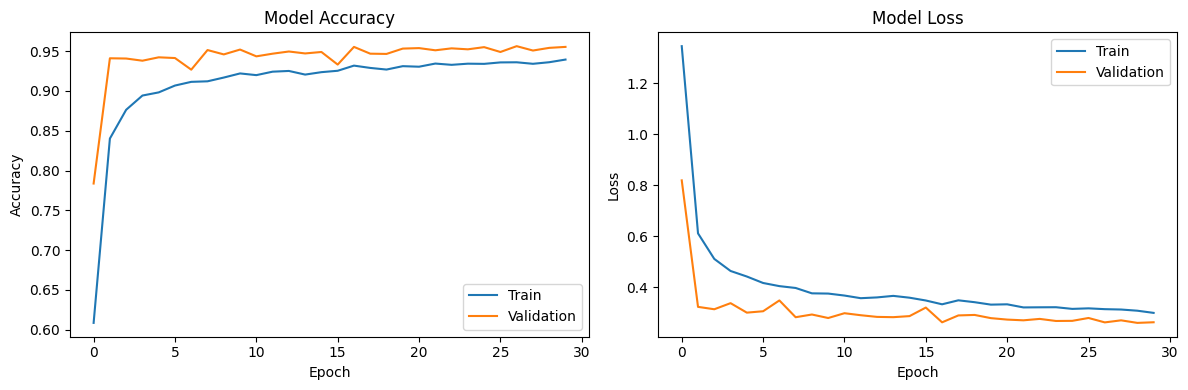

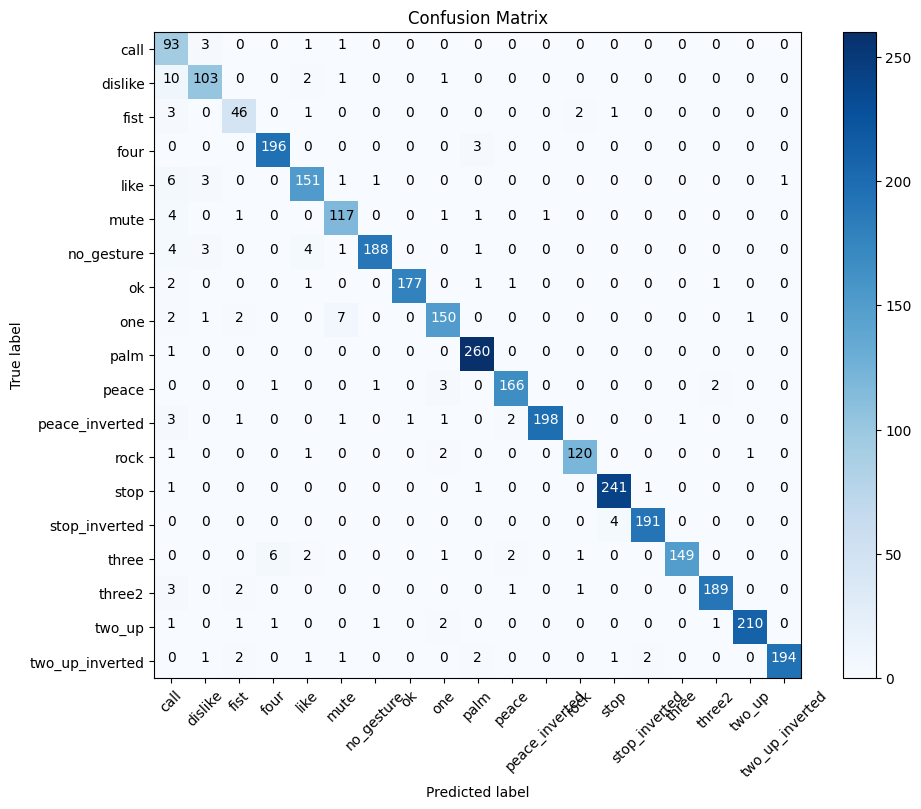

Model saved to gesture_model.h5
Label classes saved to gesture_model_labels.json
Training complete!


In [ ]:
# Full pipeline example
def main():
    # Load data
    data = load_data("landmarks_wrist_relative.json")
    print(f"Loaded {len(data)} samples")
    
    # Preprocess data
    X, y, label_encoder = preprocess_data(data)
    print(f"Features shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Classes: {label_encoder.classes_}")
    
    # Train and evaluate model
    model, history, y_true, y_pred = train_and_evaluate(X, y, epochs=30)
    
    # Plot results
    plot_training_history(history)
    plot_confusion_matrix(y_true, y_pred, label_encoder)
    
    # Save modell
    save_model(model, label_encoder)
    
    print("Training complete!")

if __name__ == "__main__":
    main()

In [34]:
import tensorflow as tf

# Load the .h5 Keras model
keras_model = tf.keras.models.load_model('gesture_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

# Save the converted .tflite model to file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Conversion complete. Saved as model.tflite")


INFO:tensorflow:Assets written to: C:\Users\Abdullah\AppData\Local\Temp\tmpt5_yx4k7\assets
Conversion complete. Saved as model.tflite
